# Unsupervised Machine Learning Project
## Task 1: Mental Health in Technology-related Jobs

**Dataset:**
Loading the file from OSMH Mental Health in Tech Survey 2022 
[Link](https://www.kaggle.com/datasets/osmihelp/osmh-mental-health-in-tech-survey-2022)

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.utils import resample
from scipy.stats import f_oneway
import matplotlib.patches as mpatches
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = pd.read_csv('responses.csv')
df.shape

(164, 126)

Print how many columns meet the condition 50+% missing values

In [2]:
missing_ratio = df.isnull().mean()
missing_cols = missing_ratio[missing_ratio > 0.5]
missing_cols_sorted = missing_cols.sort_values(ascending=False)

missing_count = len(missing_cols_sorted)
print(f"Number of columns with >50% missing values: {missing_count}")

Number of columns with >50% missing values: 65


**Data Dictionary Prep**
| name | content|
| ------------ | ------------------ |
column_name	| Name of the column in the dataset
data_type	| Data type of the column 
missing_count |	Total number of missing (NaN) values
missing_ratio |	Proportion of missing values 
example_value |	First non-null example value from the column

The data is sorted by missing_ratio in descending order to highlight the most incomplete fields.

Exported to: data_missing.xlsx for evaluation

In [3]:
data_dict = pd.DataFrame({
    'column_name': df.columns,
    'data_type': df.dtypes.values,
    'missing_count': df.isnull().sum().values,
    'missing_ratio': df.isnull().mean().values,
    'example_value': [df[col].dropna().iloc[0] if df[col].dropna().any() else None for col in df.columns]
})

data_dict.sort_values(by='missing_ratio', ascending=False, inplace=True)
data_dict.to_excel('data_missing.xlsx', index=False)

# Data Cleaning & Mapping

The following columns were dropped due to their irrelevance to the analysis and to reduce noise in the dataset:
| Column Name                              | Reason for Dropping                                |
| ---------------------------------------- | -------------------------------------------------- |
| `Have you been diagnosed with COVID-19?` | Not relevant to the focus of the analysis, many missing         |
| `What is your race?`                     | Sensitive feature, potentially introducing bias, many missing   |
| `Start Date (UTC)`,  `Submit Date (UTC)`, `Network ID`, `Tags` , `#`, `Response Type`  | Metadata, not relevant for clustering or modeling |
| `Other colums from the list of missing values, except for 'What US state or territory do you *live* in?' and 'What US state or territory do you *work* in?'`     | Over 75+% missing values, mayne open questions with limited responses relevant to a very small subgroup, making the feature unsuitable for clustering or broader analysis. |

Exported to: data_clean_dictionary.xlsx for creation of data dictionary


In [4]:
df.drop(columns=[
    'Describe the circumstances of the supportive or well handled response.',
    'How has it affected your career?',
    "Anxiety Disorder (Generalized, Social, Phobia, etc)",
    "Mood Disorder (Depression, Bipolar Disorder, etc)",
    "Psychotic Disorder (Schizophrenia, Schizoaffective, etc)",
    "Eating Disorder (Anorexia, Bulimia, etc)",
    "Attention Deficit Hyperactivity Disorder",
    "Personality Disorder (Borderline, Antisocial, Paranoid, etc)",
    "Obsessive-Compulsive Disorder",
    "Post-Traumatic Stress Disorder",
    "Stress Response Syndromes",
    "Dissociative Disorder",
    "Substance Use Disorder",
    "Addictive Disorder",
    "Other",
    "Anxiety Disorder (Generalized, Social, Phobia, etc).1",
    "Mood Disorder (Depression, Bipolar Disorder, etc).1",
    "Psychotic Disorder (Schizophrenia, Schizoaffective, etc).1",
    "Eating Disorder (Anorexia, Bulimia, etc).1",
    "Attention Deficit Hyperactivity Disorder.1",
    "Personality Disorder (Borderline, Antisocial, Paranoid, etc).1",
    "Obsessive-Compulsive Disorder.1",
    "Post-traumatic Stress Disorder",
    "Stress Response Syndromes.1",
    "Dissociative Disorder.1",
    "Substance Use Disorder.1",
    "Addictive Disorder.1",
    "Other.1",
    "Anxiety Disorder (Generalized, Social, Phobia, etc).2",
    "Mood Disorder (Depression, Bipolar Disorder, etc).2",
    "Psychotic Disorder (Schizophrenia, Schizoaffective, etc).2",
    "Eating Disorder (Anorexia, Bulimia, etc).2",
    "Attention Deficit Hyperactivity Disorder.2",
    "Personality Disorder (Borderline, Antisocial, Paranoid, etc).2",
    "Obsessive-Compulsive Disorder.2",
    "Post-traumatic Stress Disorder.1",
    "Stress Response Syndromes.2",
    "Dissociative Disorder.2",
    "Substance Use Disorder.2",
    "Addictive Disorder.2",
    "Other.2",
    'Other.3',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?',
    'If you have revealed a mental health disorder to a client or business contact, how has this affected you or the relationship?',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?',
    'If you have revealed a mental health disorder to a coworker or employee, how has this impacted you or the relationship?',
    'Do you believe your productivity is ever affected by a mental health issue?',
    'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?',
    'If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.',
    'Have you observed or experienced a *supportive or well handled response* to a mental health issue in your current or previous workplace?',
    'Have you been diagnosed with COVID-19?', 
    'What is your race?', 
    '#', 
    'Response Type', 
    'Start Date (UTC)', 
    'Submit Date (UTC)', 
    'Network ID', 
    'Tags'], inplace = True)

df.to_excel('data_clean_dictionary.xlsx', index=False)

**Naming Convention**
    
- **Snake_case** for all names (e.g., mental_health_benefits)

- **Lowercase only**, words separated by underscores _

- **Short but descriptive** names (avoid very long phrases)

- **Binary and some Yes–No–Neutral features** will use is_ or has_ prefixes when helpful (e.g., is_tech_company)

- **Score or ordered features** will end with _score _level (e.g., comfort_score, mental_disorder_presence_score)


In [5]:
rename_dict = {
    "*Are you self-employed?*": "is_self_employed",
    "How many employees does your company or organization have?": "company_employees_number",
    "Is your employer primarily a tech company/organization?": "is_tech_company",
    "Is your primary role within your company related to tech/IT?": "is_tech_role",
    "Does your employer provide mental health benefits as part of healthcare coverage?": "company_mental_health_benefits",
    "Do you know the options for mental health care available under your employer-provided health coverage?": "employer_mental_health_aid_awareness",
    "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?": "formal_mental_health_discussion",
    "Does your employer offer resources to learn more about mental health disorders and options for seeking help?": "employer_mental_health_learning_resources",
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?": "anonymity_protected",
    "If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?": "mental_health_leave_ease_score",
    "Would you feel more comfortable talking to your coworkers about your physical health or your mental health?": "coworker_comfort_discussion_physical_vs_mental",
    "Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?": "supervisor_comfort_mental_health_discussion",
    "Have you ever discussed your mental health with your employer?": "is_discussed_mental_health_with_employer",
    "Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.": "employer_mental_health_discussion_description",
    "Would you feel comfortable discussing a mental health issue with your coworkers?": "coworker_comfort_mental_health_discussion",
    "Have you ever discussed your mental health with coworkers?": "is_discussed_mental_health_with_coworkers",
    "Describe the conversation with coworkers you had about your mental health including their reactions.": "coworker_mental_health_discussion_description",
    "Have you ever had a coworker discuss their or another coworker\'s mental health with you?": "is_coworker_discussed_mental_health_with_you",
    "Describe the conversation your coworker had with you about their mental health (please do not use names).": "coworker_shared_mental_health_description",
    "Overall, how much importance does your employer place on physical health?": "physical_health_importance_level",
    "Overall, how much importance does your employer place on mental health?": "mental_health_importance_level",
    "Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?": "has_mental_health_coverage",
    "Do you know local or online resources to seek help for a mental health issue?": "public_mental_health_aid_awareness",
    "*Do you have previous employers?*": "has_previous_employers",
    'Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?': 'supervisor_comfort_mental_health_discussion',
    "Was your employer primarily a tech company/organization?": "is_previous_employer_tech_company",
    "Have your previous employers provided mental health benefits?": "previous_employer_mental_health_benefits",
    "Were you aware of the options for mental health care provided by your previous employers?": "previous_employer_mental_health_aid_awareness",
    "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?": "previous_employer_formal_mental_health_discussion",
    "Did your previous employers provide resources to learn more about mental health disorders and how to seek help?": "previous_employer_mental_health_resources",
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?": "previous_employer_anonymity_protected",
    "Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?": "previous_employer_comfort_discussion_physical_vs_mental",
    "Would you have been willing to discuss your mental health with your direct supervisor(s)?": "previous_supervisor_comfort_mental_health_discussion",
    "Did you ever discuss your mental health with your previous employer?": "is_discussed_mental_health_with_previous_employer",
    "Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.": "previous_employer_mental_health_openness_description",
    "Would you have been willing to discuss your mental health with your coworkers at previous employers?": "previous_coworker_comfort_mental_health_discussion",
    "Did you ever discuss your mental health with a previous coworker(s)?": "is_discussed_mental_health_with_previous_coworker",
    "Describe the conversation you had with your previous coworkers about your mental health including their reactions.": "previous_coworker_mental_health_openness_description",
    "Did you ever have a previous coworker discuss their or another coworker's mental health with you?": "is_previous_coworker_discussed_mental_health_with_you",
    "Describe the conversation your coworker had with you about their mental health (please do not use names)..1": "previous_coworker_mental_health__discussion_with_you",
    "Overall, how much importance did your previous employer place on physical health?": "previous_employer_physical_health_importance_level",
    "Overall, how much importance did your previous employer place on mental health?": "previous_employer_mental_health_importance_level",
    "Do you *currently* have a mental health disorder?": "current_mental_health_disorder",
    "Have you ever been *diagnosed* with a mental health disorder?": "has_been_diagnosed_mental_health_disorder",
    "Have you had a mental health disorder in the past?": "has_had_past_mental_health_disorder",
    "Have you ever sought treatment for a mental health disorder from a mental health professional?": "has_sought_mental_health_treatment",
    "Do you have a family history of mental illness?": "family_history_mental_health_disorder",
    "If you have a mental health disorder, how often do you feel that it interferes with your work *when being treated effectively?*": "mental_health_work_interference_level_with_treatment",
    "If you have a mental health disorder, how often do you feel that it interferes with your work *when* _*NOT*_* being treated effectively (i.e., when you are experiencing symptoms)?*": "mental_health_work_interference_level_without_treatment",
    "Have your observations of how another individual who discussed a mental health issue made you less likely to reveal a mental health issue yourself in your current workplace?": "observed_made_negative_influence_on_self_disclosure",
    "How willing would you be to share with friends and family that you have a mental illness?": "willingness_to_share_mental_illness_friends_and_family_level",
    "Would you be willing to bring up a physical health issue with a potential employer in an interview?": "willingness_to_disclose_physical_health_in_interview",
    "Why or why not?": "physical_health_interview_sharing_reason",
    "Would you bring up your *mental* health with a potential employer in an interview?": "willingness_to_disclose_mental_health_in_interview",
    "Why or why not?.1": "mental_health_interview_sharing_reason",
    "Are you openly identified at work as a person with a mental health issue?": "is_openly_identified_with_mental_health_issue_at_work",
    "Has being identified as a person with a mental health issue affected your career?": "has_mental_health_identification_affected_career",
    "If they knew you suffered from a mental health disorder, how do you think that your team members/co-workers would react?": "perceived_coworker_reaction_to_mental_health_disclosure_level",
    "Have you observed or experienced an *unsupportive or badly handled response* to a mental health issue in your current or previous workplace?": "has_experienced_or_observed_unsupportive_response_at_work",
    "Describe the circumstances of the badly handled or unsupportive response.": "unsupportive_response_at_work_description",
    "Have you observed or experienced a *supportive or well handled response": "has_experienced_or_observed_supportive_response_at_work",
    "Overall, how well do you think the tech industry supports employees with mental health issues?": "perceived_tech_industry_mental_health_support_score",
    "Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.": "suggestions_for_improving_mental_health_support",
    "Would you be willing to talk to one of us more extensively about your experiences with mental health issues in the tech industry? (Note that all interview responses would be used _anonymously_ and only with your permission.)": "is_willing_to_participate_in_interview",
    "What is your age?": "age",
    "What is your gender?": "gender",
    "What country do you *live* in?": "country_live",
    "What country do you *work* in?": "country_work",
    "What US state or territory do you *live* in?": "lives_in_the_US",
    "What US state or territory do you *work* in?": "workes_in_the_US"
}

df.rename(columns=rename_dict, inplace=True)

**Company Size Encoding**

Mapped `company_employees_number` into size groups:
- small: '1-5', '6-25', '26-100'
- medium: '100-500', '500-1000'
- large: 'More than 1000'
- unknown: all others or missing

Then applied one-hot encoding with `drop_first=True`.

In [6]:
df['company_employees_number'] = df['company_employees_number'].fillna('Unknown')

df['company_size'] = df['company_employees_number'].map({
    '1-5': 'small',
    '6-25': 'small',
    '26-100': 'medium',
    '100-500': 'medium',
    '500-1000': 'large',
    'More than 1000': 'large'
}).fillna('unknown')

df = pd.get_dummies(df, columns=['company_size'], drop_first=True)

**Age Outlier Handling**

One respondent had an age of 2, which was assumed to be an incomplete entry for someone in their 20s.  
To impute a more realistic value, we calculated the probability distribution of ages between 20 and 29 and replaced the outlier with the most frequent age in that range.

In [7]:
age_counts = df['age'].value_counts().sort_index()
age_counts_20s = age_counts.loc[20:29]
age_probs_20s = age_counts_20s / age_counts_20s.sum()

most_likely_age = age_probs_20s.idxmax()
df.loc[df['age'] == 2, 'age'] = most_likely_age

**Age Group Encoding**

Binned `age` into:
- under_30: ages 0–29
- 30_plus: ages 30 and above 

Applied one-hot encoding with `drop_first=True`.

In [8]:
bins = [0, 29, 44, 120]
labels = ['under_30','30-44','45_plus']

df['age_group'] = pd.cut(
    df['age'], 
    bins=bins, 
    labels=labels
)

df = pd.get_dummies(df, columns=['age_group'], drop_first=True)

**Gender Encoding**

Normalized `gender` entries by lowercasing and mapping variants to:
- male: 'male', 'm', 'man', 'dude', 'cis male', 'varón'
- female: 'female', 'f', 'female, cis-gendered'
- other: 'non-binary', 'queer', and all unrecognized values (default)

Applied one-hot encoding with `drop_first=True`.

In [9]:
df['gender'] = df['gender'].str.strip().str.lower().map({
    'male': 'male',
    'm': 'male',
    'man': 'male',
    'dude': 'male',
    'cis male': 'male',
    'varón': 'male',
    
    'female': 'female',
    'f': 'female',
    'female, cis-gendered': 'female',
    
    'non-binary': 'other',
    'queer': 'other'
}).fillna('other')

df = pd.get_dummies(df, columns=['gender'], drop_first=True)

**Country Grouping**

Mapped `country_work` and `country_live` into two broad regions:
- western: North America, Western Europe, Australia, New Zealand
- non_western: Eastern Europe, Asia, Latin America, Africa, and others

Used `.map()` with a shared dictionary. Unrecognized or missing values were labeled as `'unknown'`.

In [10]:
country_grouping = {
    'United States of America': 'western',
    'Canada': 'western',
    'United Kingdom': 'western',
    
    'Germany': 'western',
    'Netherlands': 'western',
    'France': 'western',
    'Belgium': 'western',
    'Austria': 'western',
    'Sweden': 'western',
    'Denmark': 'western',
    'Italy': 'western',
    'Spain': 'western',
    'Poland': 'western',
    
    'Russia': 'non_western',
    'Ukraine': 'non_western',
    'Romania': 'non_western',
    'Serbia': 'non_western',
    'Bosnia and Herzegovina': 'non_western',
    'Slovenia': 'non_western',
    'Lithuania': 'non_western',
    
    'India': 'non_western',
    'Indonesia': 'non_western',
    'Vietnam': 'non_western',
    'Bangladesh': 'non_western',
    'Taiwan': 'non_western',
    'Kazakhstan': 'non_western',
    'Israel': 'non_western',
    'Jordan': 'non_western',
    
    'Australia': 'western',
    'New Zealand': 'western',
    
    'Argentina': 'non_western',
    'Brazil': 'non_western',
    'Peru': 'non_western',
    'Colombia': 'non_western',
    'Uruguay': 'non_western',
    'Panama': 'non_western',
    
    'South Africa': 'non_western',
    'Somalia': 'non_western',
    
    'Aruba': 'non_western',
    'Mexico': 'non_western'
}

df['country_grouped_work'] = df['country_work'].map(country_grouping).fillna('unknown')
df['country_grouped_live'] = df['country_live'].map(country_grouping).fillna('unknown')

df = pd.get_dummies(df, columns=['country_grouped_work'], drop_first=True)
df = pd.get_dummies(df, columns=['country_grouped_live'], drop_first=True)

🔄 **Standardized Mapping of Categorical and some Likert-Type Features**  
A unified value mapping was applied to selected columns to convert various categorical or numerical responses into a common numeric scale ranging from -1.0 to 1.0.  
This enables consistent analysis across different question formats.  
🧹 All NaN values were filled with 0.0 to reflect neutral or missing responses.

In [11]:
cols_to_map_binary_yes_no_neutral = [
    'is_self_employed',
    'is_tech_company', 
    'is_tech_role', 
    'gender_male',
    'country_grouped_live_western',
    'age_group_30-44',
    'age_group_45_plus',
    'company_size_medium',
    'company_size_small',
    'company_size_unknown',
    'employer_mental_health_aid_awareness', 
    'company_mental_health_benefits',
    'formal_mental_health_discussion',
    'employer_mental_health_learning_resources',
    'anonymity_protected',
    'mental_health_leave_ease_score',
    'has_sought_mental_health_treatment',
    'coworker_comfort_discussion_physical_vs_mental',
    'is_discussed_mental_health_with_employer',
    'coworker_comfort_mental_health_discussion',
    'is_discussed_mental_health_with_coworkers',
    'is_coworker_discussed_mental_health_with_you',
    'has_mental_health_coverage',
    'public_mental_health_aid_awareness',
    'has_previous_employers',
    'previous_employer_mental_health_benefits',
    'previous_employer_mental_health_aid_awareness',
    'previous_employer_mental_health_resources',
    'previous_employer_anonymity_protected',
    'previous_employer_formal_mental_health_discussion',
    'previous_employer_comfort_discussion_physical_vs_mental',
    'previous_supervisor_comfort_mental_health_discussion',
    'is_discussed_mental_health_with_previous_employer',
    'previous_coworker_comfort_mental_health_discussion',
    'is_discussed_mental_health_with_previous_coworker',
    'is_previous_coworker_discussed_mental_health_with_you',
    'current_mental_health_disorder',
    'has_been_diagnosed_mental_health_disorder',
    'has_had_past_mental_health_disorder',
    'family_history_mental_health_disorder',
    'mental_health_work_interference_level_with_treatment',
    'mental_health_work_interference_level_without_treatment',
    'observed_made_negative_influence_on_self_disclosure',
    'willingness_to_disclose_physical_health_in_interview',
    'willingness_to_disclose_mental_health_in_interview',
    'is_openly_identified_with_mental_health_issue_at_work',
    'has_mental_health_identification_affected_career',
    'has_experienced_or_observed_unsupportive_response_at_work',
    'is_willing_to_participate_in_interview',
    'supervisor_comfort_mental_health_discussion',

    
] 

mapping_dict = {
    True: 1.0,
    False: -1.0,
    1.0: 1.0,
    0.0: -1.0,
    1: 1.0,
    'Yes': 1.0,
    'No': -1.0,
    'Maybe': 0.0,
    'Unknown': 0.0,
    "I don't know": 0.0,
    "Not eligible for coverage / NA": -1.0,
    'Very easy': 1.0,
    'Somewhat easy': 0.5,
    "Neither easy nor difficult": 0.0,
    "I don't know": 0.0,
    'Somewhat difficult': -0.5,
    'Difficult': -1.0,    
    'Mental health': 1.0,
    'Physical health': -1.0,
    "Same level of comfort for each": 0.0,
    'Yes, I know several': 1.0,
    'I know some': 0.5,
    "No, I don't know any": -1.0,
    'Yes, they all did': 1.0,
    "No, none did": -1.0,
    'Yes, I was aware of all of them': 1.0,
    'I was aware of some': 0.5,
    "N/A (none offered)": 0.0,
    "No, I only became aware later": -0.5,
    'N/A (was not aware)': -1.0,
    'Some did': 0.5,
    "None did": -1.0,
    'Yes, always': 1.0,
    'Sometimes': 0.5,
    'Yes, all of my previous supervisors': 1.0,
    'Some of my previous supervisors': 0.5,
    'No, none of my previous supervisors': -1.0,
    'Yes, at all of my previous employers': 1.0,
    'At some of my previous employers': 0.5,
    'No, at none of my previous employers': -1.0,
    'Possibly': 0.5,
    "Don't Know": 0.0,
    'Often': 1.0,
    'Sometimes': 0.5,
    'Rarely': 0.25,
    'Not applicable to me': 0.0,
    'Never': -1.0    ,
    'Yes, I experienced': 1.0,
    'Yes, I observed': 0.5,
    'Maybe/Not sure': 0.0,
    "I've always been self-employed": 0.0,

}

for col in cols_to_map_binary_yes_no_neutral:
    if col in df.columns:
        df[col] = df[col].map(mapping_dict).fillna(0.0)

**Handling of Open-Ended Text Fields**

Several open-ended text columns were mapped to corresponding binary score columns to indicate whether a response was provided. For each description column, the value was mapped as follows:

- `1` if the field is not null (response provided)
- `-1` if the field is null (no response)

This allowed the model to capture user engagement or disclosure behavior without parsing the text content. The following mappings were applied:

In [12]:
description_score_pairs = {
    "previous_employer_mental_health_openness_description": 'previous_employer_mental_health_openness_score',
    'employer_mental_health_discussion_description': 'employer_mental_health_openness_score',
    'coworker_mental_health_discussion_description': 'coworker_mental_health_openness_score',
    'coworker_shared_mental_health_description': 'coworker_shared_mental_health_openness_score',
    'previous_coworker_mental_health_openness_description': 'previous_coworker_mental_health_openness_score',
    'previous_coworker_mental_health__discussion_with_you': 'previous_coworker_discussed_mental_health_with_you_openness_score',
    'physical_health_interview_sharing_reason': 'physical_health_interview_openness_score',
    'mental_health_interview_sharing_reason': 'mental_health_interview_openness_score',
    'unsupportive_response_at_work_description': 'unsupportive_response_at_work_score',
    'suggestions_for_improving_mental_health_support': 'has_suggestions_for_improving_mental_health_support',
    'lives_in_the_US': 'us_state_live',
    'workes_in_the_US': 'us_state_work',
}

for desc_col, score_col in description_score_pairs.items():
    df[score_col] = df[desc_col].apply(lambda x: 1 if pd.notna(x) else -1)

📈 **Score Mapping and Probabilistic Imputation**

The following Likert-style importance score columns were normalized to a -1.0 to 1.0 scale and imputed using probabilistic sampling:

**Missing Value Handling:**
Missing values were filled using **random sampling based on the existing distribution** of mapped values, preserving column-level bias and balance.

In [13]:
score_mapping = {
    10.0: 1.0,
    9.0: 0.8,
    8.0: 0.6,
    7.0: 0.4,
    6.0: 0.2,
    5.0: 0.0,
    4.0: -0.2,
    3.0: -0.4,
    2.0: -0.6,
    1.0: -0.8,
    0.0: -1.0
}

score_columns = [
    'physical_health_importance_level',
    'mental_health_importance_level',
    'previous_employer_physical_health_importance_level',
    'previous_employer_mental_health_importance_level',
    'willingness_to_share_mental_illness_friends_and_family_level',
    'perceived_coworker_reaction_to_mental_health_disclosure_level',

]

np.random.seed(42)
for col in score_columns:
    df[col] = df[col].map(score_mapping)
   
    value_probs = df[col].value_counts(normalize=True)

    n_missing = df[col].isna().sum()

    if n_missing > 0 and not value_probs.empty:
        sampled_values = np.random.choice(
            value_probs.index,
            size=n_missing,
            p=value_probs.values
        )
        df.loc[df[col].isna(), col] = sampled_values



In [14]:
mapping = {
    5: 1.0,
    4: 0.5,
    3: 0.0,
    2: -0.5,
    1: -1.0,
}
df['perceived_tech_score_mapped'] = df['perceived_tech_industry_mental_health_support_score'].map(mapping)

value_probs = df['perceived_tech_score_mapped'].value_counts(normalize=True)
n_missing = df['perceived_tech_score_mapped'].isna().sum()

if n_missing > 0 and not value_probs.empty:
    np.random.seed(42)
    sampled_values = np.random.choice(
        value_probs.index,
        size=n_missing,
        p=value_probs.values
    )
    df.loc[df['perceived_tech_score_mapped'].isna(), 'perceived_tech_score_mapped'] = sampled_values
df['perceived_tech_industry_mental_health_support_score'] = df['perceived_tech_score_mapped']
df.drop(columns='perceived_tech_score_mapped', inplace=True)

## EDA & Feature Selection & Feature Selection

In [15]:
df_numeric = df.select_dtypes(include='number')

variances = df_numeric.var()

variance_df = variances.reset_index()
variance_df.columns = ['Feature', 'Variance']
top_30 = variance_df.sort_values(by='Variance', ascending=False).head(30)

print(top_30)

                                              Feature    Variance
51                                                age  119.619333
55                                    age_group_30-44    1.005985
37                 has_sought_mental_health_treatment    1.002394
70                                      us_state_work    0.967829
69                                      us_state_live    0.957654
52                                company_size_medium    0.940147
68  has_suggestions_for_improving_mental_health_su...    0.912614
56                                  age_group_45_plus    0.880293
36                has_had_past_mental_health_disorder    0.822937
50             is_willing_to_participate_in_interview    0.801287
65           physical_health_interview_openness_score    0.778543
34                     current_mental_health_disorder    0.756949
57                                        gender_male    0.754601
62       coworker_shared_mental_health_openness_score    0.754601
31  is_pre

Compound features help to involve as many dimentions as possible without cluttering the model

In [16]:
df['treatment_effectiveness_score'] = (
    df['mental_health_work_interference_level_without_treatment'] -
    df['mental_health_work_interference_level_with_treatment']
)

df['previous_work_openness_score'] = (
    df['previous_employer_mental_health_openness_score'] +
    df['previous_coworker_mental_health_openness_score'] +
    df['previous_coworker_discussed_mental_health_with_you_openness_score']

)

In [17]:
cols_to_scale = [
    'treatment_effectiveness_score',
    'previous_work_openness_score',
]

scaler = MinMaxScaler()

for col in cols_to_scale:
    if col in df.columns:
        scaled = scaler.fit_transform(df[col].values.reshape(-1, 1))
        df[col] = scaled * 2 - 1 

In [18]:
def compute_scaled_score(df, name, expression):
    score = expression.astype(int)
    scaled = MinMaxScaler().fit_transform(score.values.reshape(-1, 1))
    df[name] = scaled * 2 - 1

In [19]:
compute_scaled_score(
df,
    'positive_workplace_culture_experience_score',
(
    (df['has_experienced_or_observed_unsupportive_response_at_work'] < 0).astype(int) +
    (df['observed_made_negative_influence_on_self_disclosure'] < 0).astype(int) +
    (df['unsupportive_response_at_work_score'] < 0).astype(int) +
    (df['perceived_coworker_reaction_to_mental_health_disclosure_level'] > 0).astype(int) +
    (df['perceived_tech_industry_mental_health_support_score'] > 0.0).astype(int)
))

In [20]:
compute_scaled_score(
df,
    'disclosure_stigma_score', 
(
    (df['willingness_to_share_mental_illness_friends_and_family_level'] < 0).astype(int) +
    (df['has_mental_health_identification_affected_career'] > 0).astype(int)
))

In [21]:
compute_scaled_score(
df,
    'personal_vulnerability_score', 
(
    (df['current_mental_health_disorder'] < 0).astype(int) +
    (df['family_history_mental_health_disorder'] > 0).astype(int) +
    (df['mental_health_work_interference_level_with_treatment'] > 0).astype(int) +
    (df['mental_health_work_interference_level_without_treatment'] > 0).astype(int)
))

In [22]:
compute_scaled_score(
df,
    'support_gaps_score',  
(
    (df['has_experienced_or_observed_unsupportive_response_at_work'] > 0.0).astype(int) +
    (df['observed_made_negative_influence_on_self_disclosure'] > 0.0).astype(int) +
    (df['public_mental_health_aid_awareness'] < 0.0).astype(int) +
    (df['has_mental_health_coverage'] < 0.0).astype(int) +
    (df['employer_mental_health_aid_awareness'] < 0.0).astype(int) +
    (df['company_mental_health_benefits'] < 0.0).astype(int) +
    (df['unsupportive_response_at_work_score'] > 0.0).astype(int) +
    (df['employer_mental_health_learning_resources'] < 0.0).astype(int) +
    (df['mental_health_leave_ease_score'] < 0.0).astype(int) +
    (df['family_history_mental_health_disorder'] > 0.0).astype(int) +
    (df['willingness_to_share_mental_illness_friends_and_family_level'] < 0.0).astype(int) +
    (df['has_mental_health_identification_affected_career'] > 0.0).astype(int) +
    (df['perceived_coworker_reaction_to_mental_health_disclosure_level'] < 0.0).astype(int) 
 
))

## Final Model

In [23]:
selected_features = [
  
# Original columns  
    'has_had_past_mental_health_disorder',
    'has_been_diagnosed_mental_health_disorder',
    'has_sought_mental_health_treatment',
    'has_experienced_or_observed_unsupportive_response_at_work',
    'current_mental_health_disorder',
    'family_history_mental_health_disorder',
    'mental_health_work_interference_level_without_treatment',
    'is_openly_identified_with_mental_health_issue_at_work',  
    'gender_male',
    'company_size_small',
    'unsupportive_response_at_work_score',

# Compound colums
    'treatment_effectiveness_score',
    'support_gaps_score',
    'disclosure_stigma_score',
    'personal_vulnerability_score',
    'previous_work_openness_score',
    'positive_workplace_culture_experience_score',
]

selected_features = [col for col in selected_features if col in df.columns]
X = df[selected_features].copy()

if X.shape[0] > 0 and X.shape[1] > 0:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=12)
X_pca = pca.fit_transform(X_scaled)

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=9, prediction_data=True)
hdbscan_labels = clusterer.fit_predict(X_scaled)

df.loc[X.index, 'cluster_hdbscan'] = hdbscan_labels

print("Number of clusters found:", len(np.unique(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0))
print("Noise points:", np.sum(hdbscan_labels == -1))

Number of clusters found: 2
Noise points: 99


C:\Users\New\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\New\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Statistical Model Testing

In [24]:
explained_variance_ratio = pca.explained_variance_ratio_
retained_variance = explained_variance_ratio.sum()
information_loss = 1 - retained_variance

print(f"Total variance retained: {retained_variance:.2%}")
print(f"Information loss due to PCA: {information_loss:.2%}")

Total variance retained: 93.47%
Information loss due to PCA: 6.53%


In [25]:
mask = hdbscan_labels != -1
if np.sum(mask) > 1:
    sil_score = silhouette_score(X_pca[mask], hdbscan_labels[mask])
    print("HDBSCAN Silhouette Score:", sil_score)
else:
    print("Not enough clustered points to calculate silhouette score.")

HDBSCAN Silhouette Score: 0.508389237486992


Run 1: Silhouette = 0.377, Clusters = 8
Run 2: Silhouette = 0.503, Clusters = 11
Run 3: Silhouette = 0.584, Clusters = 11
Run 4: Silhouette = 0.577, Clusters = 14
Run 5: Silhouette = 0.475, Clusters = 12
Run 6: Silhouette = 0.483, Clusters = 10
Run 7: Silhouette = 0.519, Clusters = 13
Run 8: Silhouette = 0.523, Clusters = 12
Run 9: Silhouette = 0.556, Clusters = 7
Run 10: Silhouette = 0.684, Clusters = 13

Average Silhouette Score (filtered): 0.528


C:\Users\New\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\New\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\New\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\New\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\New\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\New\mi

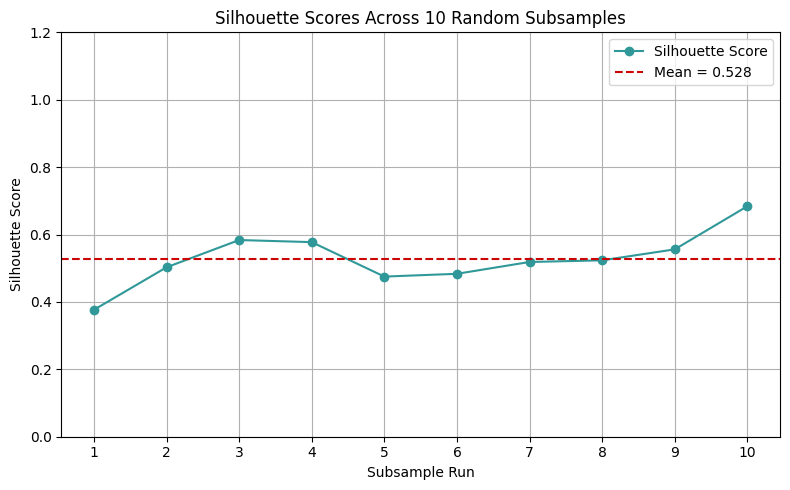

In [26]:
silhouette_scores = []
cluster_counts = []

for i in range(10):
    subset = resample(X_scaled, n_samples=int(0.80 * len(X_scaled)), random_state=i)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
    labels = clusterer.fit_predict(subset)
    
    mask = labels != -1
    n_clusters = len(set(labels[mask]))

    if n_clusters > 1 and np.sum(mask) > 2:
        score = silhouette_score(subset[mask], labels[mask])
        silhouette_scores.append(score)
        cluster_counts.append(n_clusters)
    else:
        silhouette_scores.append(np.nan)
        cluster_counts.append(0)

mean_score = np.nanmean(silhouette_scores)


for i, (score, count) in enumerate(zip(silhouette_scores, cluster_counts), 1):
    print(f"Run {i}: Silhouette = {score:.3f}, Clusters = {count}")
print(f"\nAverage Silhouette Score (filtered): {mean_score:.3f}")

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(silhouette_scores) + 1),
    silhouette_scores,
    marker='o',
    linestyle='-',
    color='#309898',
    label='Silhouette Score'
)

plt.axhline(
    y=mean_score,
    color='#CB0404',
    linestyle='--',
    label=f'Mean = {mean_score:.3f}'
)
plt.title("Silhouette Scores Across 10 Random Subsamples")
plt.xlabel("Subsample Run")
plt.ylabel("Silhouette Score")
plt.ylim(0, 1.2)
plt.xticks(range(1, len(silhouette_scores) + 1))
plt.grid(True)
plt.legend()
plt.savefig("Silhouette_Scores_Across_10_Random_Subsamples.jpg", dpi=300, bbox_inches='tight', format='jpg')
plt.tight_layout()
plt.show()

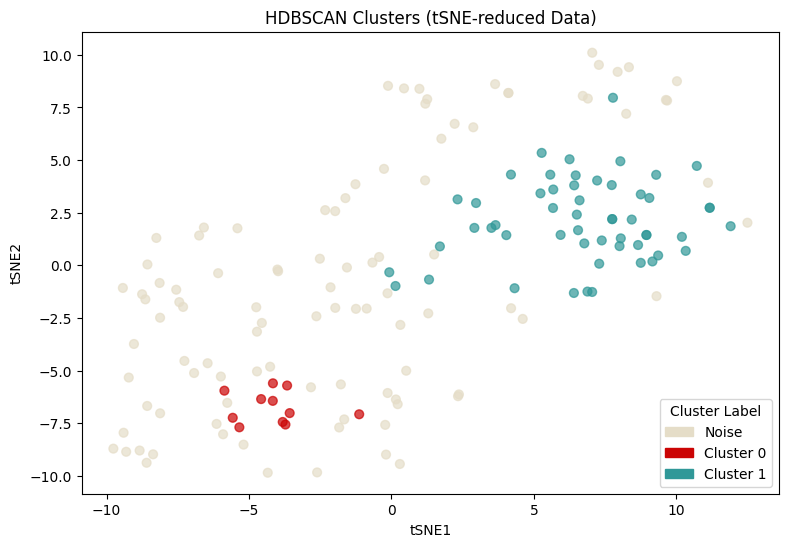

In [27]:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)

custom_colors = {
    -1: '#E5DDC8', 
     0: '#CB0404',
     1: '#309898',
}

colors = [custom_colors[label] for label in hdbscan_labels]

plt.figure(figsize=(9,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, s=40, alpha=0.7)
plt.title('HDBSCAN Clusters (tSNE-reduced Data)')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')

legend_elements = [
    mpatches.Patch(color=custom_colors[label], label=f'Cluster {label}' if label != -1 else 'Noise')
    for label in sorted(custom_colors)
]
plt.legend(handles=legend_elements, title='Cluster Label',loc='lower right')
plt.savefig("HDBSCAN_Clusters.jpg", dpi=300, bbox_inches='tight', format='jpg')
plt.show()

                                                    F-statistic  p-value
disclosure_stigma_score                                  4.8802   0.0088
previous_work_openness_score                             6.3219   0.0023
company_size_small                                       6.5094   0.0019
is_openly_identified_with_mental_health_issue_a...       6.6146   0.0017
gender_male                                              7.2520   0.0010
positive_workplace_culture_experience_score              8.4765   0.0003
unsupportive_response_at_work_score                     11.9646   0.0000
support_gaps_score                                      12.0625   0.0000
has_experienced_or_observed_unsupportive_respon...      14.4858   0.0000
treatment_effectiveness_score                           15.2694   0.0000
family_history_mental_health_disorder                   16.5654   0.0000
has_been_diagnosed_mental_health_disorder               26.2971   0.0000
personal_vulnerability_score                       

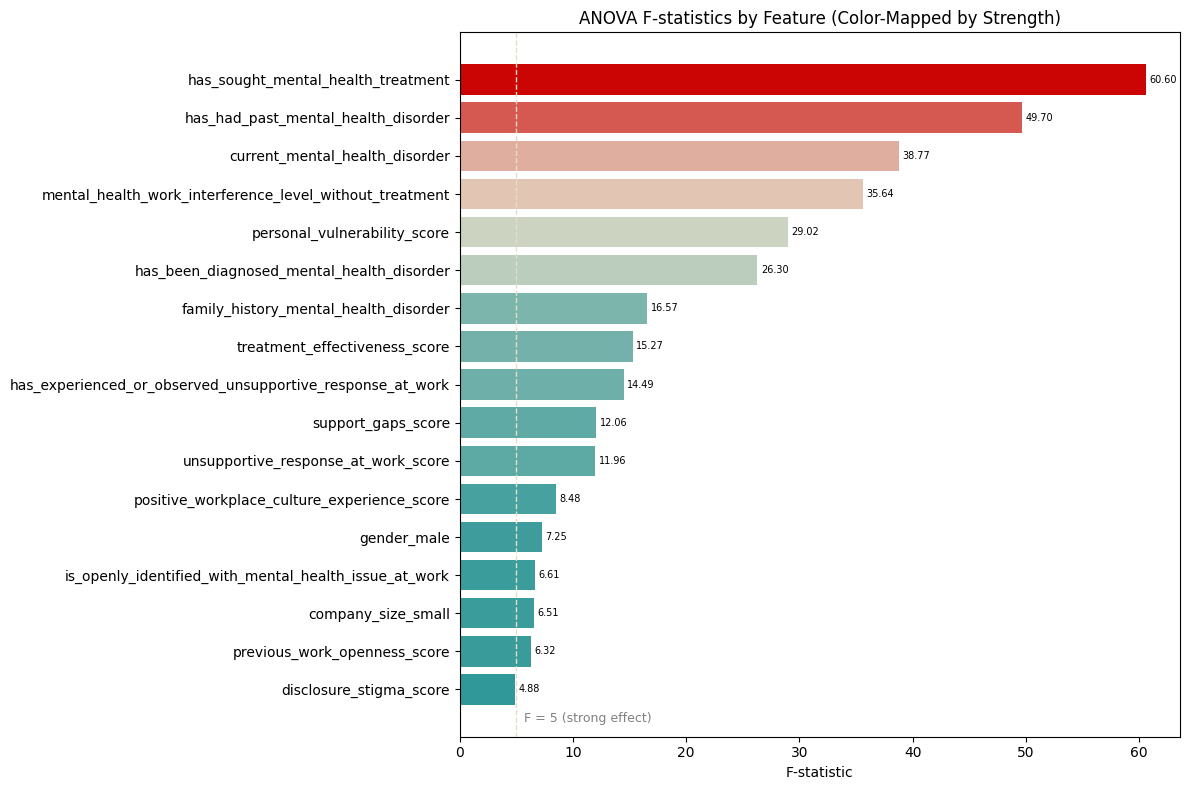

In [28]:
anova_results = {}

for feature in selected_features:
    try:
        groups = [df[df['cluster_hdbscan'] == label][feature].dropna()
                  for label in df['cluster_hdbscan'].unique()]
        
        if sum(len(g) > 0 for g in groups) >= 2:
            f_stat, p_val = f_oneway(*groups)
            anova_results[feature] = {'F-statistic': f_stat, 'p-value': p_val}
        else:
            anova_results[feature] = {'F-statistic': None, 'p-value': None}
    
    except Exception as e:
        anova_results[feature] = {'F-statistic': None, 'p-value': str(e)}

anova_df = pd.DataFrame(anova_results).T.round(4)
anova_df = anova_df.sort_values('F-statistic')

print(anova_df)

anova_df_plot = anova_df.reset_index().rename(columns={'index': 'Feature'})
anova_df_plot = anova_df_plot.sort_values("F-statistic", ascending=True)

custom_cmap = LinearSegmentedColormap.from_list(
    'f_stat_cmap',
    ['#309898', '#E5DDC8', '#CB0404'],
    N=256
)

f_stats = anova_df_plot['F-statistic'].values
norm = Normalize(vmin=f_stats.min(), vmax=max(f_stats.max(), 5)) 
colors = [custom_cmap(norm(f)) for f in f_stats]

plt.figure(figsize=(12, 8))
bars = plt.barh(
    anova_df_plot['Feature'],
    anova_df_plot['F-statistic'],
    color=colors
)

for bar, val in zip(bars, anova_df_plot['F-statistic']):
    plt.text(val + 0.3, bar.get_y() + bar.get_height()/2, f"{val:.2f}",
             va='center', ha='left', fontsize=7)

plt.axvline(5, color='#E5DDC8', linestyle='--', linewidth=1)
plt.text(5.7, -0.85, 'F = 5 (strong effect)', fontsize=9, color='gray')

plt.xlabel("F-statistic")
plt.title("ANOVA F-statistics by Feature (Color-Mapped by Strength)")
plt.tight_layout()
plt.savefig("ANOVA_F-statistics_by_Feature.jpg", dpi=300, bbox_inches='tight', format='jpg')
plt.show()

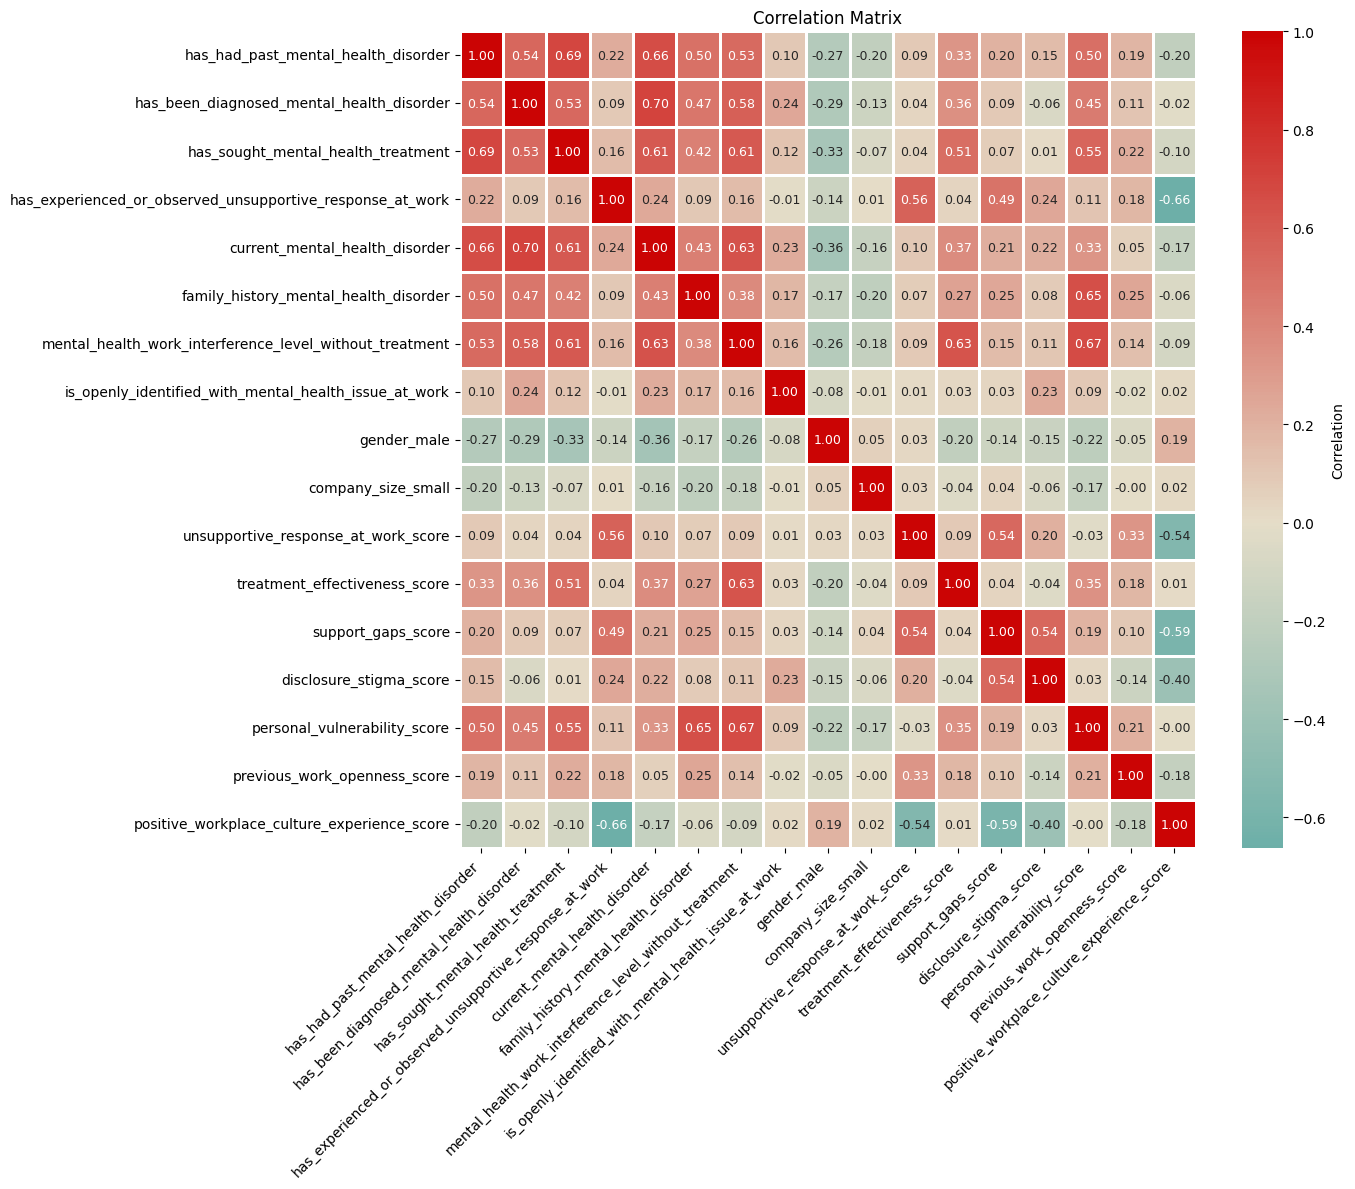

In [29]:
features_to_check = [
    
# Original columns  
    'has_had_past_mental_health_disorder',
    'has_been_diagnosed_mental_health_disorder',
    'has_sought_mental_health_treatment',
    'has_experienced_or_observed_unsupportive_response_at_work',
    'current_mental_health_disorder',
    'family_history_mental_health_disorder',
    'mental_health_work_interference_level_without_treatment',
    'is_openly_identified_with_mental_health_issue_at_work',  
    'gender_male',
    'company_size_small',
    'unsupportive_response_at_work_score',

# Compound colums
    'treatment_effectiveness_score',
    'support_gaps_score',
    'disclosure_stigma_score',
    'personal_vulnerability_score',
    'previous_work_openness_score',
    'positive_workplace_culture_experience_score',
    
]

custom_cmap = LinearSegmentedColormap.from_list(
    'custom_corr',
    ['#309898', '#E5DDC8', '#CB0404'],
    N=256
)

corr_matrix = df[features_to_check].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap=custom_cmap,
    center=0,
    fmt=".2f",
    linewidths=2,
    cbar_kws={'label': 'Correlation'},
    annot_kws={"size": 9}
)
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("Correlation_Matrix.jpg", dpi=300, bbox_inches='tight', format='jpg')
plt.show()

                                              Feature        VIF
0                                               const  15.961936
1                 has_had_past_mental_health_disorder   2.704638
2           has_been_diagnosed_mental_health_disorder   2.653182
3                  has_sought_mental_health_treatment   2.917824
4   has_experienced_or_observed_unsupportive_respo...   2.156918
5                      current_mental_health_disorder   4.313365
6               family_history_mental_health_disorder   2.622835
7   mental_health_work_interference_level_without_...   4.849254
8   is_openly_identified_with_mental_health_issue_...   1.215288
9                                         gender_male   1.272888
10                                 company_size_small   1.132561
11                unsupportive_response_at_work_score   2.139984
12                      treatment_effectiveness_score   2.076521
13                                 support_gaps_score   2.547365
14                       

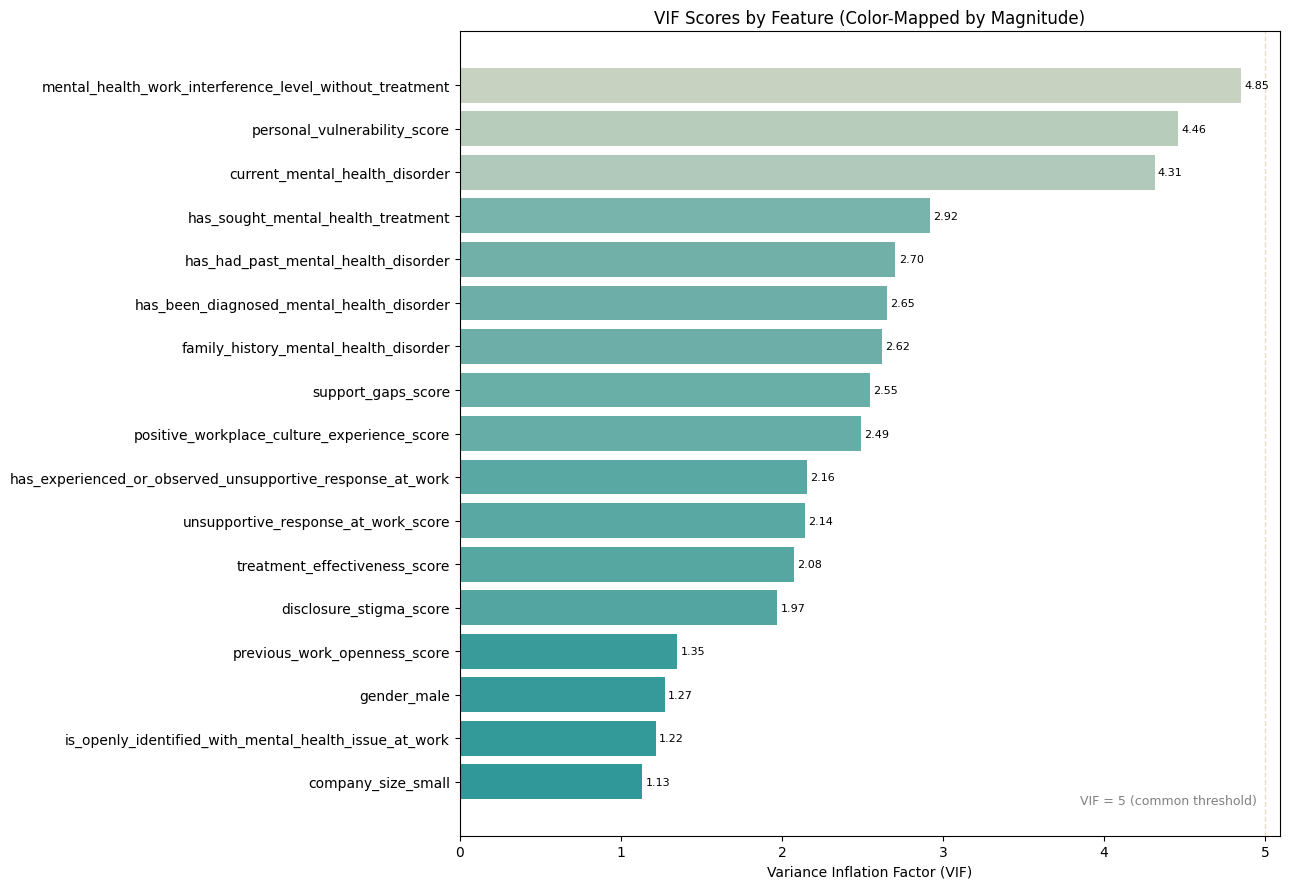

In [30]:
selected_columns = [
    
# Original columns  
    'has_had_past_mental_health_disorder',
    'has_been_diagnosed_mental_health_disorder',
    'has_sought_mental_health_treatment',
    'has_experienced_or_observed_unsupportive_response_at_work',
    'current_mental_health_disorder',
    'family_history_mental_health_disorder',
    'mental_health_work_interference_level_without_treatment',
    'is_openly_identified_with_mental_health_issue_at_work',  
    'gender_male',
    'company_size_small',
    'unsupportive_response_at_work_score',

# Compound colums
    'treatment_effectiveness_score',
    'support_gaps_score',
    'disclosure_stigma_score',
    'personal_vulnerability_score',
    'previous_work_openness_score',
    'positive_workplace_culture_experience_score',

]

X = df[selected_columns].dropna()
X_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)


vif_plot = vif_data[vif_data["Feature"] != "const"].sort_values("VIF", ascending=True)

custom_cmap = LinearSegmentedColormap.from_list(
    'vif_cmap',
    ['#309898', '#E5DDC8', '#CB0404'],
    N=256
)

norm = Normalize(vmin=vif_plot['VIF'].min(), vmax=max(vif_plot['VIF'].max(), 10))
colors = [custom_cmap(norm(v)) for v in vif_plot['VIF']]

plt.figure(figsize=(13, 9))
bars = plt.barh(
    vif_plot['Feature'],
    vif_plot['VIF'],
    color=colors
)

for bar, val in zip(bars, vif_plot['VIF']):
    plt.text(val + 0.02, bar.get_y() + bar.get_height()/2, f"{val:.2f}",
             va='center', ha='left', fontsize=8)

plt.axvline(5, color='#E5DDC8', linestyle='--', linewidth=1)
plt.text(3.85, -0.5, 'VIF = 5 (common threshold)', fontsize=9, color='gray')

plt.xlabel("Variance Inflation Factor (VIF)")
plt.title("VIF Scores by Feature (Color-Mapped by Magnitude)")
plt.tight_layout()
plt.savefig("Variance_Inflation_Factor.jpg", dpi=300, bbox_inches='tight', format='jpg')
plt.show()



**Number of data points per cluster**

In [31]:
cluster_counts = df['cluster_hdbscan'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']
print(cluster_counts)



   cluster  count
0     -1.0     99
1      1.0     54
2      0.0     11


**Silouette score per cluster**

In [32]:
hdbscan_labels_with_noise = hdbscan_labels.copy()
hdbscan_labels_with_noise[hdbscan_labels_with_noise == -1] = 99

sil_all = silhouette_samples(X_pca, hdbscan_labels_with_noise)

df_all = pd.DataFrame({
    'cluster': hdbscan_labels_with_noise,
    'original_cluster': hdbscan_labels,
    'silhouette_score': sil_all
})

cluster_silhouette = df_all.groupby('original_cluster')['silhouette_score'].mean().reset_index()
print(cluster_silhouette)

   original_cluster  silhouette_score
0                -1         -0.197743
1                 0          0.450709
2                 1          0.505426


## Subclustering the Noise

In [33]:
noise_mask = df['cluster_hdbscan'] == -1
X_noise = X_scaled[noise_mask]

Gaussian Mixture Noise Points Subclustering

In [34]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_noise)
score = silhouette_score(X_noise, gmm_labels)
print("GMM Silhouette Score:", score)

GMM Silhouette Score: 0.12035800256684041


C:\Users\New\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Kmeans Noise Points Subclustering

In [35]:
kmeans_noise = KMeans(n_clusters=3, random_state=42)
noise_labels = kmeans_noise.fit_predict(X_noise)

df.loc[noise_mask, 'noise_subcluster'] = noise_labels

for k in range(2, 5):
    kmeans_noise = KMeans(n_clusters=k, random_state=42)
    noise_labels = kmeans_noise.fit_predict(X_noise)
    score = silhouette_score(X_noise, noise_labels)
    print(f"k = {k}, silhouette score = {score:.3f}")

k = 2, silhouette score = 0.147
k = 3, silhouette score = 0.132
k = 4, silhouette score = 0.125


C:\Users\New\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\New\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\New\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\New\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows wi

HDBSCAN Noise Points Subclustering

In [36]:
new_hdb = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=5)
noise_recluster_labels = new_hdb.fit_predict(X_noise)
if len(set(noise_recluster_labels)) > 1:
    print("Silhouette Score:", silhouette_score(X_noise, noise_recluster_labels))


Silhouette Score: 0.0009453158960357548


C:\Users\New\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\New\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Profiling

In [37]:
df.groupby('cluster_hdbscan')[selected_features].mean().T




cluster_hdbscan,-1.0,0.0,1.0
has_had_past_mental_health_disorder,0.222222,0.909091,-0.842593
has_been_diagnosed_mental_health_disorder,0.323232,0.909091,0.000000
has_sought_mental_health_treatment,0.313131,1.000000,-0.962963
has_experienced_or_observed_unsupportive_response_at_work,-0.020202,-0.545455,-0.611111
current_mental_health_disorder,0.126263,0.954545,-0.750000
family_history_mental_health_disorder,-0.060606,0.363636,-0.740741
mental_health_work_interference_level_without_treatment,0.527778,0.863636,0.032407
is_openly_identified_with_mental_health_issue_at_work,-0.656566,-1.000000,-1.000000
gender_male,0.313131,0.454545,0.851852
company_size_small,-0.595960,-1.000000,-0.962963


**Visualization of profilers** 

In [38]:
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_corr',
    ['#309898', '#E5DDC8', '#CB0404'],
    N=256
)

cluster_means = df.groupby('cluster_hdbscan')[selected_features].mean().T
for feature in cluster_means.index:
    values = cluster_means.loc[feature]
    norm = Normalize(vmin=-1, vmax=1)
    colors = [custom_cmap(norm(v)) for v in values]

    title_clean = feature.replace("_", " ")
    filename = f"{feature}_by_cluster.jpg"

    plt.figure(figsize=(11, 3))
    bars = plt.barh(values.index.astype(str), values.values, color=colors)

    for i, v in enumerate(values.values):
        label_x = v - 0.0005 if v < 0 else v + 0.0005
        ha = 'right' if v < 0 else 'left'
        plt.text(label_x, i, f"{v:.2f}", va='center', ha=ha, fontsize=7)

    plt.title(title_clean, fontsize=9)
    plt.xlabel("Mean Value", fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.axvline(0, color='gray', linewidth=0.8)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')
    plt.close()

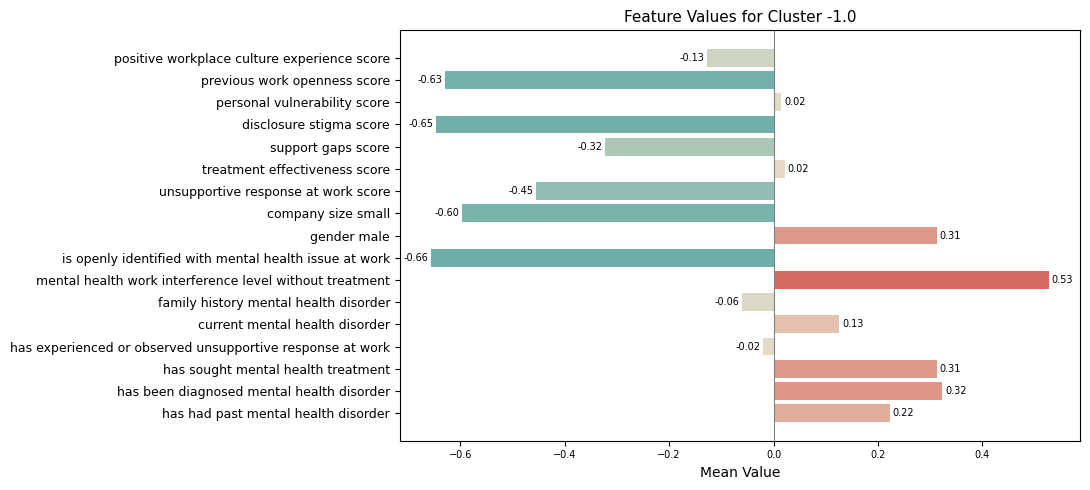

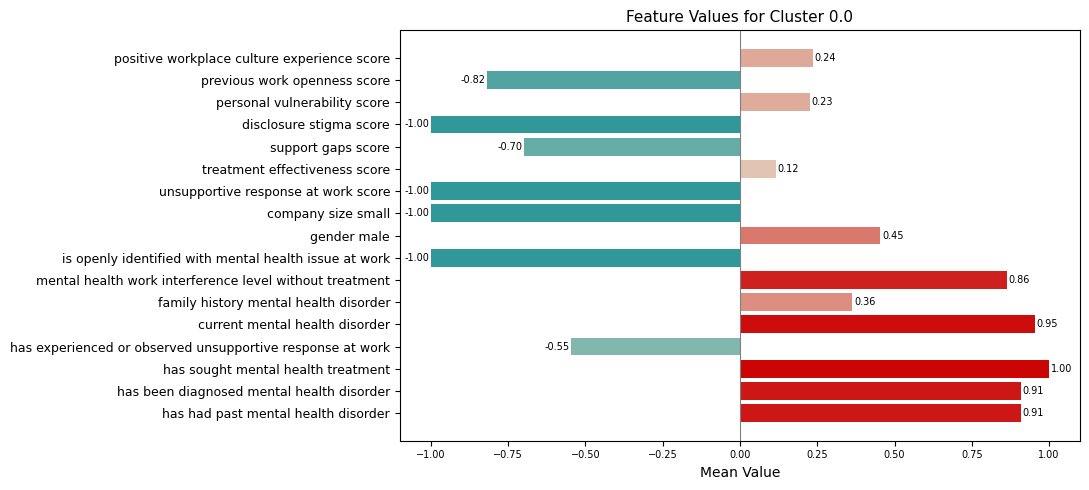

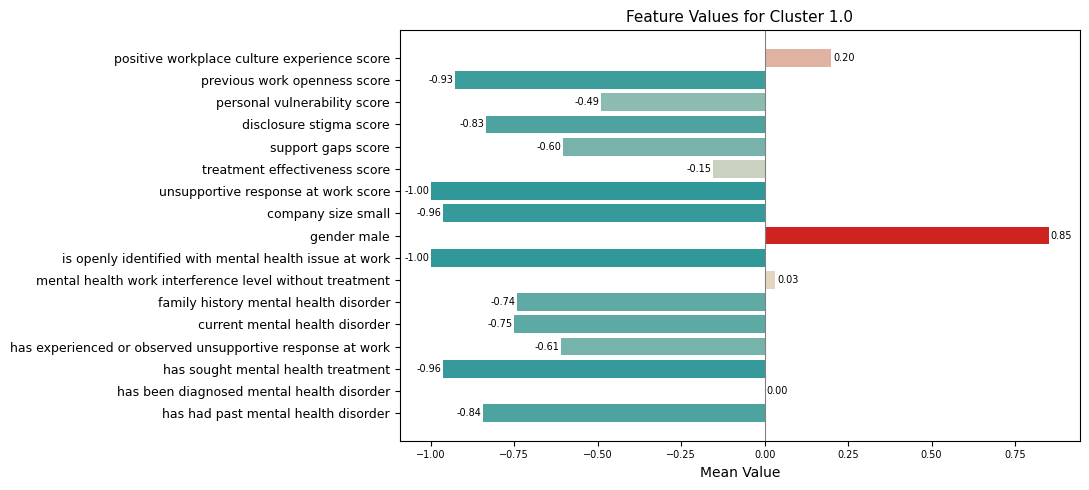

In [41]:
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_corr',
    ['#309898', '#E5DDC8', '#CB0404'],
    N=256
)

norm = Normalize(vmin=-1, vmax=1)

for cluster in cluster_means.columns:
    plt.figure(figsize=(11, 5))
    values = cluster_means[cluster]

    colors = [custom_cmap(norm(v)) for v in values]
    labels = [label.replace("_", " ") for label in values.index]
    bars = plt.barh(labels, values.values, color=colors)

    for i, v in enumerate(values.values):
        plt.text(
            v + 0.005 if v >= 0 else v - 0.005,
            i,
            f"{v:.2f}",
            va='center',
            ha='left' if v >= 0 else 'right',
            fontsize=7
        )

    plt.title(f"Feature Values for Cluster {cluster}", fontsize=11)
    plt.axvline(0, color='gray', linewidth=0.8)
    plt.xlabel("Mean Value")
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=9)
    plt.tight_layout()

    filename = f"cluster_{cluster}_feature_values.jpg"
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')
    plt.show()
    plt.close()